In [23]:
# ============================================================================
# CELDA 1: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL
# ============================================================================
%run ./00_template.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path

# Librerías de Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Configuración de gráficos
sns.set_style("whitegrid")
print("✅ Librerías cargadas y entorno configurado.")

=== 🌍 Template PEP1 Configurado Exitosamente ===
📂 Base Dir       : /home/jovyan
💾 GeoDatabase    : ✅ Encontrada
📊 Censo CSV      : ✅ Encontrado
✅ Librerías cargadas y entorno configurado.


In [24]:
# ============================================================================
# CELDA 2: CARGA, TRANSFORMACIÓN Y LIMPIEZA DE DATOS
# ============================================================================
# 1. Definir rutas
INPUT_CSV = OUTPUTS_DIR / "accesibilidad_otp_final.csv"
OUTPUT_PARQUET = OUTPUTS_DIR / "comunas_accesibilidad_wide.parquet"

print(f"📂 Leyendo archivo generado por OTP: {INPUT_CSV}")

if not INPUT_CSV.exists():
    raise FileNotFoundError("❌ No existe el CSV. Ejecuta el Notebook 03 primero.")

# 2. Cargar datos brutos
df_long = pd.read_csv(INPUT_CSV)

# 3. Pivotear (Transformar de formato Largo a Ancho)
# Fila = Comuna, Columnas = Categorías de servicio, Valor = Minutos
acc = df_long.pivot_table(
    index="cod", 
    columns="cat", 
    values="minutos", 
    aggfunc="min" 
).reset_index()

# Renombrar para estandarizar
acc = acc.rename(columns={"cod": "cod_comuna"})

# 4. Enriquecer con nombres de comunas (desde el GeoPackage)
gdf_base = gpd.read_file(RUTA_GPKG, layer="comunas_rm_censo")
mapping = gdf_base[["CUT_COM", "COMUNA"]].copy()
mapping["CUT_COM"] = mapping["CUT_COM"].astype(str)
acc["cod_comuna"] = acc["cod_comuna"].astype(str)

acc = acc.merge(mapping, left_on="cod_comuna", right_on="CUT_COM", how="left")
acc = acc.rename(columns={"NOM_COM": "comuna"})
acc = acc.drop(columns=["CUT_COM"])

# 5. Imputación de Valores Nulos
# Si un valor es NaN, significa que no hay ruta o está muy lejos.
# Lo reemplazamos con un valor alto (ej: 120 min) para "penalizar" esa comuna en el clustering.
numeric_cols = [c for c in acc.columns if c not in ["cod_comuna", "comuna"]]

for col in numeric_cols:
    nulls = acc[col].isna().sum()
    if nulls > 0:
        val_penalizacion = 120 # 2 horas
        print(f"⚠️ {col}: {nulls} comunas sin cobertura. Imputando {val_penalizacion} min.")
        acc[col] = acc[col].fillna(val_penalizacion)

# 6. Guardar dataset listo para ML
acc.to_parquet(OUTPUT_PARQUET, index=False)

print(f"\n✅ Datos procesados y guardados en: {OUTPUT_PARQUET}")
print("   Dimensiones:", acc.shape)
acc.head()

📂 Leyendo archivo generado por OTP: /home/jovyan/outputs/accesibilidad_otp_final.csv
⚠️ almacenes_barrio: 10 comunas sin cobertura. Imputando 120 min.
⚠️ areas_verdes: 6 comunas sin cobertura. Imputando 120 min.
⚠️ bancos: 12 comunas sin cobertura. Imputando 120 min.
⚠️ bencineras: 10 comunas sin cobertura. Imputando 120 min.
⚠️ bomberos: 10 comunas sin cobertura. Imputando 120 min.
⚠️ carabineros: 14 comunas sin cobertura. Imputando 120 min.
⚠️ deporte_infra: 2 comunas sin cobertura. Imputando 120 min.
⚠️ educacion_escolar: 4 comunas sin cobertura. Imputando 120 min.
⚠️ educacion_superior: 25 comunas sin cobertura. Imputando 120 min.
⚠️ estadios: 28 comunas sin cobertura. Imputando 120 min.
⚠️ ferias_libres: 12 comunas sin cobertura. Imputando 120 min.
⚠️ iglesias: 8 comunas sin cobertura. Imputando 120 min.
⚠️ malls: 24 comunas sin cobertura. Imputando 120 min.
⚠️ metro_tren: 40 comunas sin cobertura. Imputando 120 min.
⚠️ micro: 10 comunas sin cobertura. Imputando 120 min.
⚠️ munici

,cod_comuna,almacenes_barrio,areas_verdes,bancos,bencineras,bomberos,carabineros,deporte_infra,educacion_escolar,educacion_superior,...,ferias_libres,iglesias,malls,metro_tren,micro,municipios,museos,salud,supermercados,COMUNA
0,13101,2.733333,7.383333,8.466667,7.466667,10.433333,16.116667,3.633333,8.783333,1.600000,...,8.500000,5.583333,17.100000,120.0,0.816667,120.000000,1.583333,6.483333,3.483333,Santiago
1,13102,8.766667,3.566667,13.500000,7.233333,13.383333,30.316667,2.833333,3.800000,13.916667,...,7.666667,11.750000,120.000000,120.0,2.416667,26.933333,17.550000,7.333333,25.716667,Cerrillos
2,13103,5.716667,0.283333,15.500000,13.350000,11.483333,1.833333,1.200000,2.933333,120.000000,...,4.533333,13.066667,23.550000,120.0,0.333333,32.733333,120.000000,4.650000,10.866667,Cerro Navia
3,13104,10.650000,1.750000,23.266667,5.966667,15.616667,24.166667,1.783333,3.450000,120.000000,...,6.733333,4.200000,120.000000,120.0,3.066667,25.516667,120.000000,13.300000,15.200000,Conchalí
4,13105,8.883333,3.783333,8.500000,9.766667,15.166667,13.766667,3.783333,1.216667,120.000000,...,18.000000,4.250000,20.133333,120.0,5.483333,21.833333,120.000000,2.566667,19.600000,El Bosque


In [25]:
# ============================================================================
# CELDA 3: ESTADÍSTICAS DESCRIPTIVAS
# ============================================================================
print("📊 Resumen estadístico de tiempos de viaje (minutos):")
desc = acc[numeric_cols].describe().T
display(desc)

# Validaciones de seguridad
assert len(acc) >= 5, f"❌ Muy pocas comunas ({len(acc)}). Revisa el Notebook 03."
assert len(numeric_cols) >= 2, "❌ Necesitas al menos 2 categorías de servicios para hacer clustering."

📊 Resumen estadístico de tiempos de viaje (minutos):


,count,mean,std,min,25%,50%,75%,max
almacenes_barrio,43.0,35.055426,47.779979,0.650000,5.725000,9.033333,31.366667,120.0
areas_verdes,43.0,25.601938,40.842203,0.266667,3.441667,6.850000,19.575000,120.0
bancos,43.0,45.518605,48.429506,3.616667,9.616667,16.683333,120.000000,120.0
bencineras,43.0,37.076744,46.669229,2.433333,7.350000,11.316667,29.683333,120.0
bomberos,43.0,41.483333,44.199632,3.933333,14.366667,17.616667,37.125000,120.0
carabineros,43.0,51.097287,48.897334,1.833333,13.716667,24.166667,120.000000,120.0
deporte_infra,43.0,14.436434,26.163857,0.050000,2.641667,5.683333,10.550000,120.0
educacion_escolar,43.0,21.725969,35.447112,1.216667,3.508333,6.450000,19.550000,120.0
educacion_superior,43.0,78.760465,50.772619,1.600000,21.116667,120.000000,120.000000,120.0
estadios,43.0,86.308915,46.886227,9.433333,27.358333,120.000000,120.000000,120.0


✅ Columnas seleccionadas para el análisis (Features):
['almacenes_barrio', 'areas_verdes', 'bancos', 'bencineras', 'bomberos', 'carabineros', 'deporte_infra', 'educacion_escolar', 'educacion_superior', 'estadios', 'ferias_libres', 'iglesias', 'malls', 'metro_tren', 'micro', 'municipios', 'museos', 'salud', 'supermercados']

📈 Varianza explicada: 63.20%


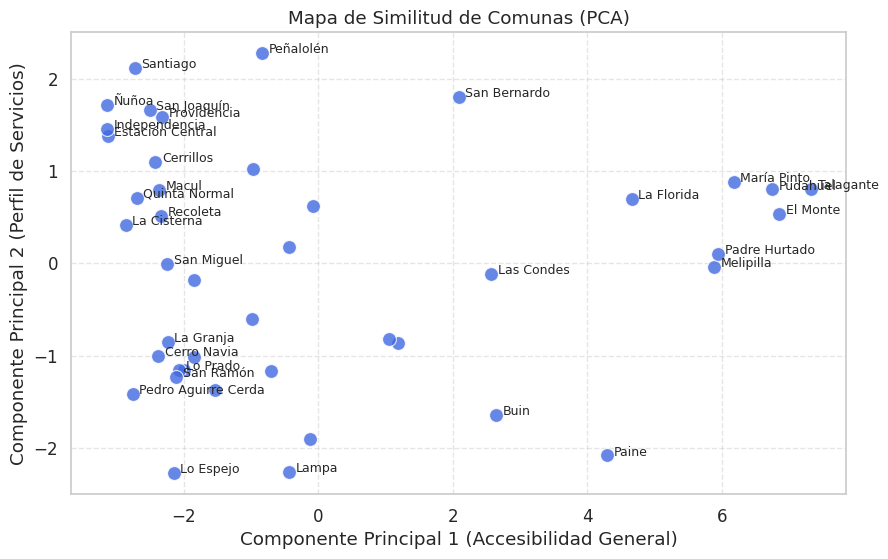

In [26]:
# ============================================================================
# CELDA 4: PREPROCESAMIENTO Y PCA (CORREGIDA)
# ============================================================================
# 1. FILTRADO INTELIGENTE DE COLUMNAS
# Pandas tiene una función para seleccionar solo números automáticamente.
# Esto evita que se cuelen columnas de texto como "Santiago".
X = acc.select_dtypes(include=['number']).copy()

# Por seguridad, eliminamos 'cod_comuna' si es que quedó como número por error
if "cod_comuna" in X.columns:
    X = X.drop(columns=["cod_comuna"])

# Verificar qué columnas vamos a usar
print("✅ Columnas seleccionadas para el análisis (Features):")
print(X.columns.tolist())

# Asegurarnos de que no esté vacío
if X.empty or len(X.columns) < 2:
    raise ValueError("❌ Error: No se encontraron columnas numéricas suficientes.")

# 2. Estandarizar (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA para visualizar en 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"\n📈 Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")

# 4. Graficar
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], alpha=0.8, s=100, color='royalblue')

# Etiquetar algunas comunas para referencia
# Usamos acc["comuna"] (o la columna de nombre que tengas) para las etiquetas
nombres_comunas = acc["comuna"] if "comuna" in acc.columns else acc["COMUNA"]

for i, txt in enumerate(nombres_comunas):
    # Solo etiquetamos si están lejos del centro (outliers visuales) para no llenar el mapa
    if abs(X_pca[i,0]) > 2 or abs(X_pca[i,1]) > 2:
        plt.annotate(txt, (X_pca[i,0]+0.1, X_pca[i,1]), fontsize=9)

plt.title("Mapa de Similitud de Comunas (PCA)")
plt.xlabel("Componente Principal 1 (Accesibilidad General)")
plt.ylabel("Componente Principal 2 (Perfil de Servicios)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

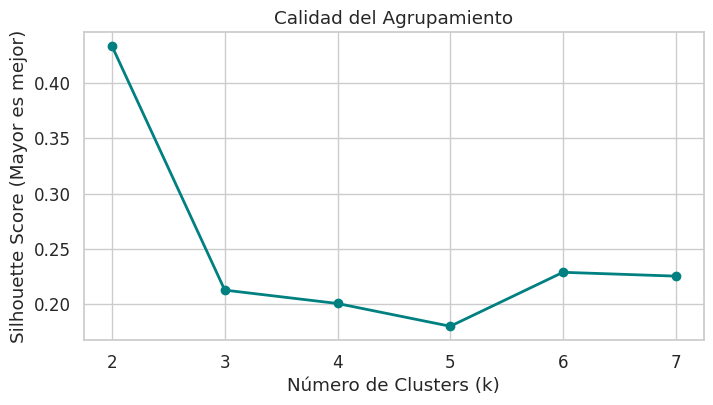

In [27]:
# ============================================================================
# CELDA 5: DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS (K)
# ============================================================================
scores = []
K_range = range(2, 8) # Probaremos dividir Santiago en 2 a 7 zonas

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(K_range, scores, marker="o", linestyle="-", color="teal", linewidth=2)
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score (Mayor es mejor)")
plt.title("Calidad del Agrupamiento")
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [28]:
# ============================================================================
# CELDA 6: APLICACIÓN DEL MODELO FINAL (K-MEANS)
# ============================================================================
# --- AJUSTA ESTE VALOR SEGÚN EL GRÁFICO ANTERIOR ---
K_OPTIMO = 4
# ---------------------------------------------------

kmeans = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=10)
acc["cluster"] = kmeans.fit_predict(X_scaled)

print(f"✅ Clustering completado con K={K_OPTIMO}")
print("\nDistribución de comunas por cluster:")
print(acc["cluster"].value_counts().sort_index())

# Mostrar ejemplos por cluster
for k in range(K_OPTIMO):
    print(f"\n📁 Cluster {k}:", acc[acc["cluster"]==k]["COMUNA"].head(5).tolist(), "...")

✅ Clustering completado con K=4

Distribución de comunas por cluster:
cluster
0     8
1    16
2    12
3     7
Name: count, dtype: int64

📁 Cluster 0: ['La Florida', 'Pudahuel', 'Paine', 'Melipilla', 'María Pinto'] ...

📁 Cluster 1: ['Cerro Navia', 'Conchalí', 'El Bosque', 'La Granja', 'La Pintana'] ...

📁 Cluster 2: ['Santiago', 'Cerrillos', 'Estación Central', 'Independencia', 'La Cisterna'] ...

📁 Cluster 3: ['Huechuraba', 'Las Condes', 'Maipú', 'Puente Alto', 'San Bernardo'] ...


In [29]:
# ============================================================================
# CELDA 7: INTERPRETACIÓN DE LOS PERFILES (CORREGIDA)
# ============================================================================
# 1. Identificar dinámicamente las columnas numéricas de servicios
# Buscamos solo columnas numéricas
cols_analisis = acc.select_dtypes(include=['number']).columns.tolist()

# Limpiamos la lista: No queremos promediar el 'cluster' ni códigos
columnas_a_excluir = ["cluster", "cod_comuna", "cod", "CUT_COM"]
cols_analisis = [c for c in cols_analisis if c not in columnas_a_excluir]

print(f"📊 Generando perfil basado en {len(cols_analisis)} servicios:")
print(cols_analisis)

# 2. Calcular el tiempo promedio por cluster
# Agrupamos por cluster y solo pedimos el promedio de las columnas filtradas
perfil = acc.groupby("cluster")[cols_analisis].mean()

print("\n⏱️ Tiempos promedio de viaje (minutos) por cluster:")
print("(Verde 🟩 = Menor tiempo = Mejor accesibilidad)")
print("(Rojo 🟥 = Mayor tiempo = Peor accesibilidad)")

# 3. Mostrar tabla con colores
# Usamos 'RdYlGn_r' invertido: Verde para valores bajos (bueno), Rojo para altos (malo)
display(perfil.style.background_gradient(cmap="RdYlGn_r"))

📊 Generando perfil basado en 19 servicios:
['almacenes_barrio', 'areas_verdes', 'bancos', 'bencineras', 'bomberos', 'carabineros', 'deporte_infra', 'educacion_escolar', 'educacion_superior', 'estadios', 'ferias_libres', 'iglesias', 'malls', 'metro_tren', 'micro', 'municipios', 'museos', 'salud', 'supermercados']

⏱️ Tiempos promedio de viaje (minutos) por cluster:
(Verde 🟩 = Menor tiempo = Mejor accesibilidad)
(Rojo 🟥 = Mayor tiempo = Peor accesibilidad)


,almacenes_barrio,areas_verdes,bancos,bencineras,bomberos,carabineros,deporte_infra,educacion_escolar,educacion_superior,estadios,ferias_libres,iglesias,malls,metro_tren,micro,municipios,museos,salud,supermercados
cluster,,,,,,,,,,,,,,,,,,,
0,120.000000,90.570833,114.295833,120.000000,107.277083,107.250000,47.768750,81.960417,116.197917,120.000000,120.000000,114.695833,120.000000,112.006250,107.235417,120.000000,120.000000,94.997917,101.687500
1,15.353125,6.045833,14.164583,11.943750,25.331250,28.939583,3.758333,6.062500,90.058333,77.496875,19.019792,8.001042,57.053125,106.597917,18.284375,32.269792,120.000000,9.065625,21.042708
2,5.216667,4.726389,11.827778,7.572222,21.373611,25.679167,3.800000,4.451389,24.069444,55.944444,20.404167,7.976389,52.323611,120.000000,1.698611,34.015278,18.711111,9.658333,10.033333
3,34.161905,31.838095,96.338095,50.333333,37.683333,81.142857,18.983333,18.302381,103.907143,120.000000,48.778571,39.402381,109.880952,120.000000,42.988095,106.804762,107.171429,23.290476,63.911905


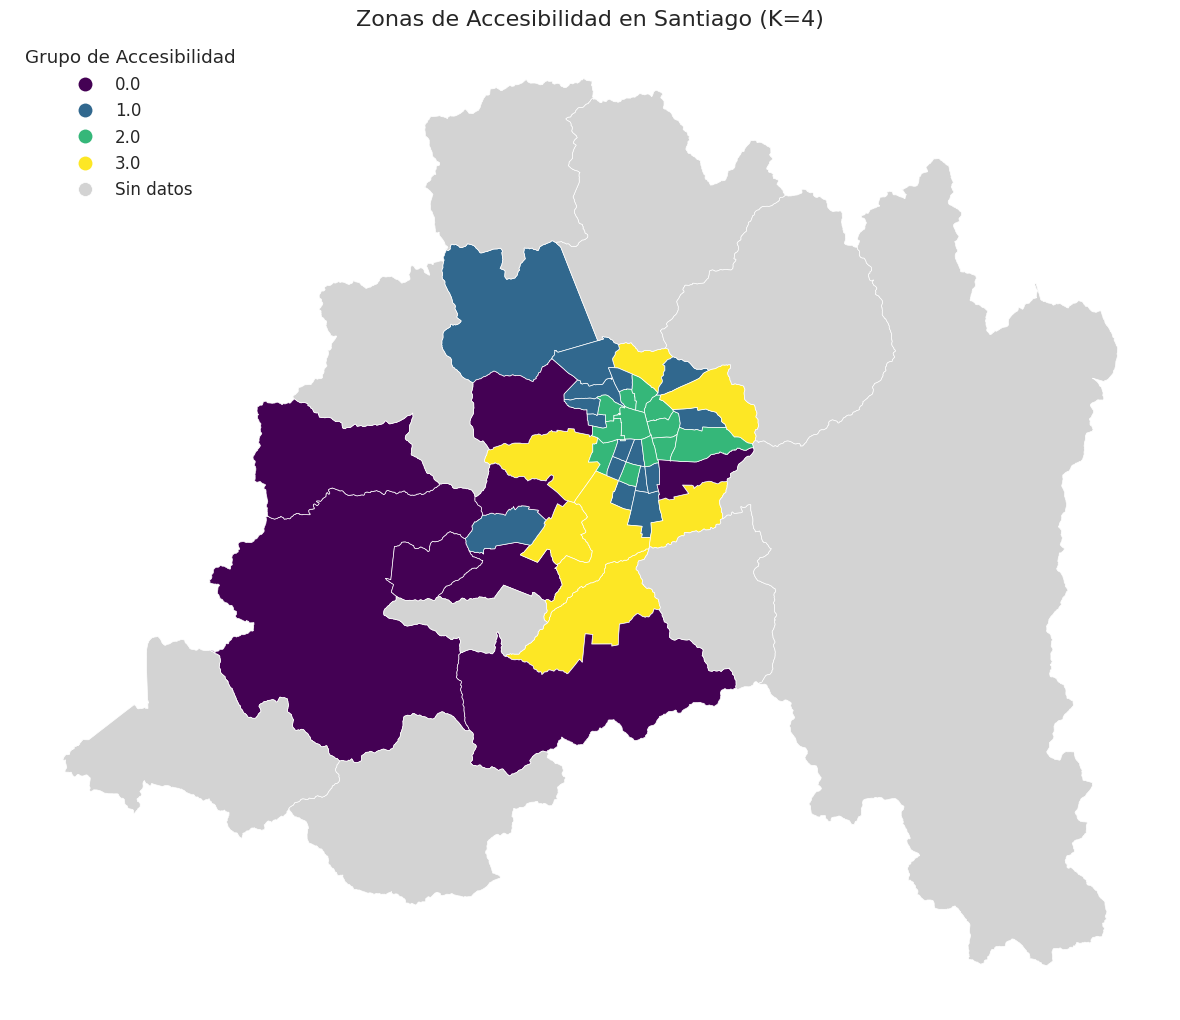

In [30]:
# ============================================================================
# CELDA 8: VISUALIZACIÓN ESPACIAL (MAPA)
# ============================================================================
# 1. Cargar geometrías
gdf_map = gpd.read_file(RUTA_GPKG, layer="comunas_rm_censo")
gdf_map["CUT_COM"] = gdf_map["CUT_COM"].astype(str)

# 2. Unir resultados del clustering
gdf_final = gdf_map.merge(acc[["cod_comuna", "cluster"]], left_on="CUT_COM", right_on="cod_comuna", how="left")

# 3. Plotear
fig, ax = plt.subplots(figsize=(12, 12))

gdf_final.plot(
    column="cluster",
    cmap="viridis",        # Paleta de colores
    categorical=True,      # Tratar clusters como categorías, no números continuos
    legend=True,
    legend_kwds={'title': 'Grupo de Accesibilidad', 'loc': 'upper left'},
    missing_kwds={'color': 'lightgrey', 'label': 'Sin datos'},
    edgecolor="white",
    linewidth=0.5,
    ax=ax
)

ax.set_title(f"Zonas de Accesibilidad en Santiago (K={K_OPTIMO})", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [31]:
# ============================================================================
# CELDA 9: GUARDADO FINAL Y EXPORTACIÓN
# ============================================================================
# 1. Asignamos nombres legibles a los clusters (OPCIONAL, PERO RECOMENDADO)
# Ajusta estos nombres según lo que viste en tu mapa K=4 y la tabla de promedios.
# Ejemplo basado en tu imagen (verifica con tus datos reales cuál es cuál):
# Si Cluster 0 es lento (Maipú), Cluster 1 es medio (Centro), etc.

# Para saber cuál es cuál, miramos los promedios de nuevo:
print("Promedios para identificar etiquetas:")
display(acc.groupby("cluster")[cols_analisis].mean().mean(axis=1))

# Supongamos (¡Revisa los números!) que:
# 0 = Periferia Poniente
# 1 = Periferia Norte
# 2 = Cono Oriente (Tiempos más bajos)
# 3 = Eje Centro-Sur
# dic_etiquetas = {0: "Poniente", 1: "Norte", 2: "Oriente (Alta Acceso)", 3: "Centro-Sur"}
# acc["nombre_cluster"] = acc["cluster"].map(dic_etiquetas)

# 2. Guardar CSV Final
OUTPUT_FINAL = OUTPUTS_DIR / "comunas_accesibilidad_clusters.csv"
acc.to_csv(OUTPUT_FINAL, index=False)

print(f"💾 Archivo final guardado en: {OUTPUT_FINAL}")
print("¡Felicidades! Has completado el análisis de accesibilidad.")

Promedios para identificar etiquetas:


cluster
0    107.154934
1     35.288871
2     23.130629
3     66.048371
dtype: float64

💾 Archivo final guardado en: /home/jovyan/outputs/comunas_accesibilidad_clusters.csv
¡Felicidades! Has completado el análisis de accesibilidad.


🔍 Generando mapa de calor de microzonas...
📐 Espaciado de grilla: 100m
🔨 Generando grilla de puntos...
✅ Generados 1539547 puntos de muestreo en la región
✅ Datos de accesibilidad unidos: 480426 puntos con datos
🔄 Calculando variabilidad intra-comunal...
📈 Preparando interpolación con 480426 puntos válidos...
🎨 Generando mapa de calor...


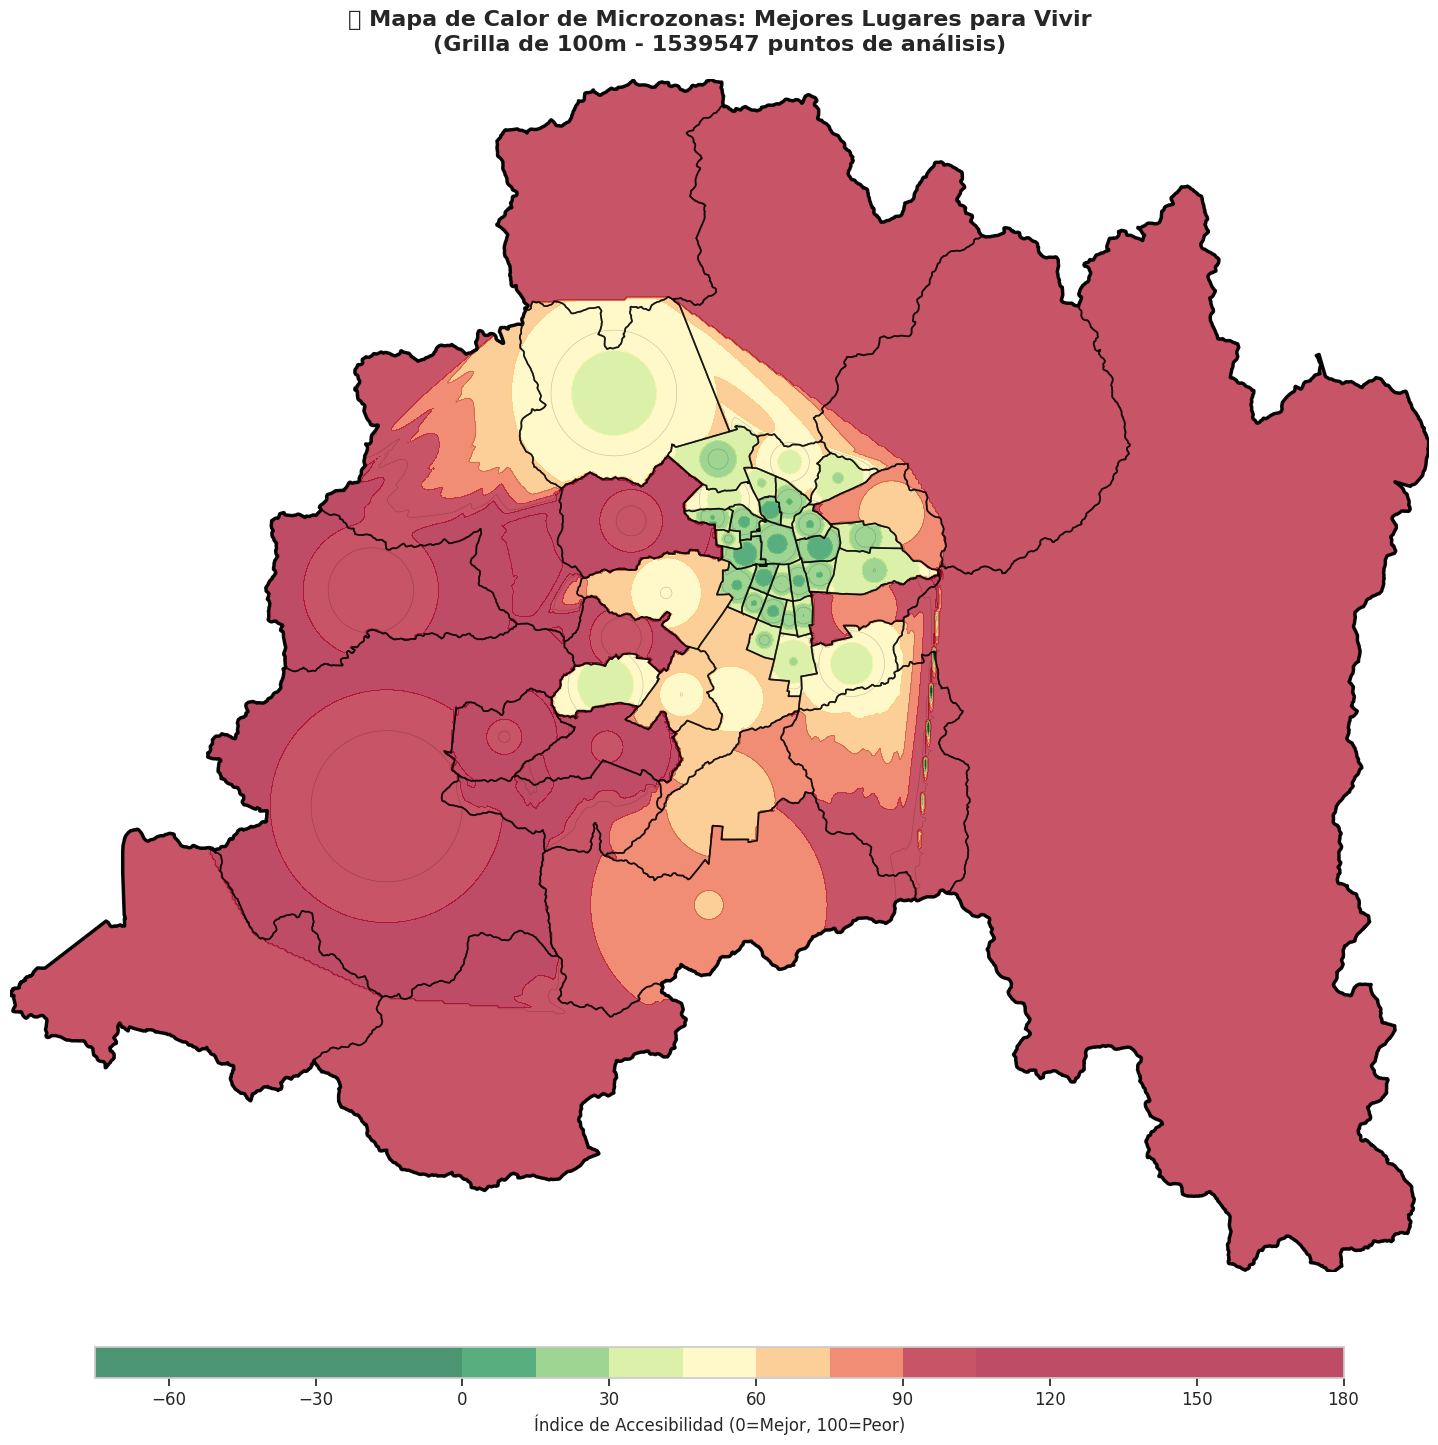


🏆 TOP 10 MICROZONAS CON MEJOR ACCESIBILIDAD:


<Figure size 640x480 with 0 Axes>


💾 Exportando resultados...

✅ Análisis de microzonas completado con éxito!

💾 Datos exportados:

💾 Datos exportados:

✅ Análisis de microzonas completado con éxito!
   • Grilla completa: /home/jovyan/outputs/microzonas_accesibilidad.csv
   • Grilla completa: /home/jovyan/outputs/microzonas_accesibilidad.csv
   • Top 50 microzonas: /home/jovyan/outputs/top_microzonas_para_vivir.csv
   • Top 50 microzonas: /home/jovyan/outputs/top_microzonas_para_vivir.csv


In [ ]:
# ============================================================================
# CELDA 10: MAPA DE CALOR DE MICROZONAS - MEJORES LUGARES PARA VIVIR
# ============================================================================
# Esta celda crea un mapa de calor detallado con grilla de puntos dentro de cada comuna
# para identificar las mejores microzonas específicas para vivir

import numpy as np
from shapely.geometry import Point
from scipy.interpolate import griddata

print("🔍 Generando mapa de calor de microzonas...")

# 0. CALCULAR ÍNDICE DE ACCESIBILIDAD BASE (si no existe)
if 'indice_accesibilidad' not in acc.columns:
    print("📊 Calculando índice de accesibilidad...")
    accesibilidad_index = acc[cols_analisis].mean(axis=1)
    acc["indice_accesibilidad"] = (
        (accesibilidad_index - accesibilidad_index.min()) / 
        (accesibilidad_index.max() - accesibilidad_index.min()) * 100
    )

# 1. CONFIGURACIÓN DE LA GRILLA
GRID_SPACING = 100  # Metros entre puntos (ajusta para más/menos detalle)
print(f"📐 Espaciado de grilla: {GRID_SPACING}m")

# 2. Cargar geometrías y proyectar a métrico (UTM)
gdf_map_utm = gdf_map.to_crs(epsg=32719)  # UTM 19S para medir en metros

# 3. GENERAR PUNTOS DE GRILLA DENTRO DE CADA COMUNA
grid_points = []
comuna_ids = []

print("🔨 Generando grilla de puntos...")
for idx, comuna_row in gdf_map_utm.iterrows():
    # Obtener bounds de la comuna
    bounds = comuna_row.geometry.bounds  # (minx, miny, maxx, maxy)
    
    # Crear grilla de puntos
    x_coords = np.arange(bounds[0], bounds[2], GRID_SPACING)
    y_coords = np.arange(bounds[1], bounds[3], GRID_SPACING)
    
    # Generar puntos y verificar que estén dentro de la comuna
    for x in x_coords:
        for y in y_coords:
            point = Point(x, y)
            if comuna_row.geometry.contains(point):
                grid_points.append(point)
                comuna_ids.append(comuna_row["CUT_COM"])

print(f"✅ Generados {len(grid_points)} puntos de muestreo en la región")

# 4. CREAR GEODATAFRAME DE LA GRILLA
gdf_grid = gpd.GeoDataFrame(
    {'cod_comuna': comuna_ids, 'geometry': grid_points},
    crs=32719
)

# 5. CALCULAR ÍNDICE DE ACCESIBILIDAD PARA CADA PUNTO
# Unimos con los datos de accesibilidad de la comuna
gdf_grid = gdf_grid.merge(
    acc[['cod_comuna', 'indice_accesibilidad']], 
    on='cod_comuna', 
    how='left'
)

# Verificar que se unieron los datos correctamente
if gdf_grid['indice_accesibilidad'].isna().all():
    print("⚠️ Error: No se pudieron unir los datos. Verificando tipos de datos...")
    print(f"Tipo cod_comuna en grid: {gdf_grid['cod_comuna'].dtype}")
    print(f"Tipo cod_comuna en acc: {acc['cod_comuna'].dtype}")
    # Asegurar mismo tipo
    gdf_grid['cod_comuna'] = gdf_grid['cod_comuna'].astype(str)
    gdf_grid = gdf_grid.merge(
        acc[['cod_comuna', 'indice_accesibilidad']], 
        on='cod_comuna', 
        how='left',
        suffixes=('', '_y')
    )
    if 'indice_accesibilidad_y' in gdf_grid.columns:
        gdf_grid['indice_accesibilidad'] = gdf_grid['indice_accesibilidad_y']
        gdf_grid = gdf_grid.drop(columns=['indice_accesibilidad_y'])

print(f"✅ Datos de accesibilidad unidos: {gdf_grid['indice_accesibilidad'].notna().sum()} puntos con datos")

# 6. AGREGAR VARIABILIDAD ESPACIAL BASADA EN DISTANCIA AL CENTROIDE
# Puntos más cerca del centro de la comuna tienen mejor accesibilidad
print("🔄 Calculando variabilidad intra-comunal...")

for cod in gdf_grid['cod_comuna'].unique():
    if pd.isna(cod):
        continue
        
    # Obtener geometría de la comuna
    comuna_match = gdf_map_utm[gdf_map_utm['CUT_COM'] == cod]
    if comuna_match.empty:
        continue
        
    comuna_geom = comuna_match.geometry.iloc[0]
    centroid = comuna_geom.centroid
    
    # Calcular distancia de cada punto al centroide
    mask = gdf_grid['cod_comuna'] == cod
    distances = gdf_grid[mask].geometry.distance(centroid)
    
    # Normalizar distancias (0 en el centro, 1 en el borde)
    max_dist = distances.max()
    if max_dist > 0:
        normalized_dist = distances / max_dist
        
        # Penalizar puntos lejanos (ajuste del 0-30% según distancia)
        penalty = normalized_dist * 30  # Hasta 30 puntos de penalización
        
        # Actualizar índice
        gdf_grid.loc[mask, 'indice_accesibilidad'] = (
            gdf_grid.loc[mask, 'indice_accesibilidad'] + penalty
        )

# 7. PREPARAR DATOS PARA INTERPOLACIÓN
gdf_grid['x'] = gdf_grid.geometry.x
gdf_grid['y'] = gdf_grid.geometry.y

# Filtrar puntos sin datos
gdf_grid_valid = gdf_grid[gdf_grid['indice_accesibilidad'].notna()].copy()

print(f"📈 Preparando interpolación con {len(gdf_grid_valid)} puntos válidos...")

# Crear grilla regular para interpolación suave
x_min, y_min, x_max, y_max = gdf_map_utm.total_bounds
xi = np.linspace(x_min, x_max, 500)  # Resolución de interpolación
yi = np.linspace(y_min, y_max, 500)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolar valores
zi = griddata(
    (gdf_grid_valid['x'], gdf_grid_valid['y']),
    gdf_grid_valid['indice_accesibilidad'],
    (xi_grid, yi_grid),
    method='cubic',
    fill_value=100  # Valor para áreas sin datos
)

# 8. CREAR MAPA DE CALOR CON CONTORNOS Y CLIP A LA REGIÓN
print("🎨 Generando mapa de calor...")
fig, ax = plt.subplots(figsize=(16, 16))

# Crear la máscara de la región (unión de todas las comunas)
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
import shapely.geometry

region_union = gdf_map_utm.geometry.unary_union

# Convertir geometría de Shapely a Path de matplotlib
def shapely_to_mpl_path(geom):
    """Convierte una geometría de Shapely a un Path de matplotlib"""
    if geom.geom_type == 'Polygon':
        coords = list(geom.exterior.coords)
        codes = [MplPath.MOVETO] + [MplPath.LINETO] * (len(coords) - 2) + [MplPath.CLOSEPOLY]
        return MplPath(coords, codes)
    elif geom.geom_type == 'MultiPolygon':
        vertices = []
        codes = []
        for poly in geom.geoms:
            coords = list(poly.exterior.coords)
            vertices.extend(coords)
            codes.extend([MplPath.MOVETO] + [MplPath.LINETO] * (len(coords) - 2) + [MplPath.CLOSEPOLY])
        return MplPath(vertices, codes)
    return None

# Crear el path de recorte
clip_path = shapely_to_mpl_path(region_union)
clip_patch = PathPatch(clip_path, transform=ax.transData)

# Plotear el mapa de calor interpolado
contourf = ax.contourf(
    xi_grid, yi_grid, zi,
    levels=20,
    cmap='RdYlGn_r',
    alpha=0.7,
    vmin=0, vmax=100
)

# APLICAR CLIP: El mapa de calor solo se muestra dentro de la región
for collection in contourf.collections:
    collection.set_clip_path(clip_patch)

# Agregar contornos de línea para mejor lectura (también con clip)
contours = ax.contour(
    xi_grid, yi_grid, zi,
    levels=10,
    colors='black',
    alpha=0.2,
    linewidths=0.5
)

for collection in contours.collections:
    collection.set_clip_path(clip_patch)

# Plotear bordes de comunas (líneas internas nítidas y visibles)
gdf_map_utm.boundary.plot(ax=ax, edgecolor='black', linewidth=1.2, alpha=0.7, zorder=5)

# Plotear el borde exterior de la región más grueso
region_boundary = region_union.boundary
if region_boundary.geom_type == 'MultiLineString':
    for line in region_boundary.geoms:
        ax.plot(*line.xy, color='black', linewidth=2.5, alpha=0.95, zorder=10)
else:
    ax.plot(*region_boundary.xy, color='black', linewidth=2.5, alpha=0.95, zorder=10)

# Colorbar
cbar = plt.colorbar(contourf, ax=ax, orientation='horizontal', 
                    pad=0.05, shrink=0.8, aspect=40)
cbar.set_label('Índice de Accesibilidad (0=Mejor, 100=Peor)', fontsize=12)

ax.set_title(
    '🗺️ Mapa de Calor de Microzonas: Mejores Lugares para Vivir\n'
    f'(Grilla de {GRID_SPACING}m - {len(grid_points)} puntos de análisis)',
    fontsize=16,
    fontweight='bold',
    pad=20
)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.show()

# 9. IDENTIFICAR LAS TOP 10 MICROZONAS MÁS ACCESIBLES
gdf_grid_wgs = gdf_grid_valid.to_crs(epsg=4326)  # Convertir a lat/lon para reporte
top_microzonas = gdf_grid_valid.nsmallest(10, 'indice_accesibilidad')
top_microzonas_wgs = gdf_grid_wgs.nsmallest(10, 'indice_accesibilidad')

print("\n🏆 TOP 10 MICROZONAS CON MEJOR ACCESIBILIDAD:")
print("=" * 70)
for idx, (row, row_wgs) in enumerate(zip(top_microzonas.itertuples(), top_microzonas_wgs.itertuples()), 1):
    # Buscar nombre de comuna de forma segura
    comuna_match = gdf_map[gdf_map['CUT_COM'] == row.cod_comuna]
    if not comuna_match.empty:
        comuna_nombre = comuna_match['COMUNA'].iloc[0]
    else:
        comuna_nombre = row.cod_comuna
        
# Solo el borde de la región (sin relleno)
region_boundary_wgs = gdf_map.geometry.unary_union.boundary
if region_boundary_wgs.geom_type == 'MultiLineString':
    for line in region_boundary_wgs.geoms:
        ax2.plot(*line.xy, color='black', linewidth=2.5, alpha=0.95, zorder=10)
else:
    ax2.plot(*region_boundary_wgs.xy, color='black', linewidth=2.5, alpha=0.95, zorder=10)

# Bordes de comunas (líneas nítidas y visibles)
gdf_map.boundary.plot(ax=ax2, edgecolor='darkgray', linewidth=0.8, alpha=0.6)

# Plotear todos los puntos de la grilla coloreados
gdf_grid_wgs_plot = gdf_grid_valid.to_crs(epsg=4326)
gdf_grid_wgs_plot.plot(
    ax=ax2,
    column='indice_accesibilidad',
    cmap='RdYlGn_r',
    markersize=8,
    alpha=0.6,
    legend=True,
    legend_kwds={'label': 'Índice de Accesibilidad', 'shrink': 0.8}
)

# Destacar las mejores microzonas
top_10_wgs = gdf_grid_wgs.nsmallest(10, 'indice_accesibilidad')
top_10_wgs.plot(ax=ax2, color='blue', markersize=80, marker='*', 
                edgecolor='yellow', linewidth=2, label='Top 10 Microzonas', zorder=5)

ax2.set_title('Mapa de Puntos: Mejores Microzonas (★ = Top 10)', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

# 11. EXPORTAR RESULTADOS
print("\n💾 Exportando resultados...")
# Guardar datos de grilla
output_grid = OUTPUTS_DIR / "microzonas_accesibilidad.csv"
gdf_grid_export = gdf_grid_valid.to_crs(epsg=4326)
gdf_grid_export['lat'] = gdf_grid_export.geometry.y
gdf_grid_export['lon'] = gdf_grid_export.geometry.x
gdf_grid_export[['cod_comuna', 'lat', 'lon', 'indice_accesibilidad']].to_csv(
    output_grid, index=False
)

# Guardar top microzonas
output_top = OUTPUTS_DIR / "top_microzonas_para_vivir.csv"
top_50 = gdf_grid_export.nsmallest(50, 'indice_accesibilidad')
top_50[['cod_comuna', 'lat', 'lon', 'indice_accesibilidad']].to_csv(
    output_top, index=False
)


print(f"\n✅ Análisis de microzonas completado con éxito!")
print(f"\n💾 Datos exportados:")
print(f"   • Grilla completa: {output_grid}")
print(f"   • Top 50 microzonas: {output_top}")

In [45]:
# Print top microzonas with community names
print("\n🏆 TOP 10 MICROZONAS CON MEJOR ACCESIBILIDAD:")
print("=" * 80)

for idx, row in enumerate(top_microzonas_wgs.itertuples(), 1):
    # Find community name
    comuna_match = gdf_map[gdf_map['CUT_COM'] == row.cod_comuna]
    if not comuna_match.empty:
        comuna_nombre = comuna_match['COMUNA'].iloc[0]
    else:
        comuna_nombre = row.cod_comuna
    
    print(f"{idx:2d}. {comuna_nombre:20s} | Lat: {row.geometry.y:8.5f} | Lon: {row.geometry.x:9.5f} | Score: {row.indice_accesibilidad:6.2f}")

print("=" * 80)


🏆 TOP 10 MICROZONAS CON MEJOR ACCESIBILIDAD:
 1. Independencia        | Lat: -33.41462 | Lon: -70.66489 | Score:   0.51
 2. Ñuñoa                | Lat: -33.45811 | Lon: -70.59836 | Score:   0.71
 3. Estación Central     | Lat: -33.46436 | Lon: -70.70125 | Score:   0.84
 4. Estación Central     | Lat: -33.46437 | Lon: -70.70017 | Score:   0.88
 5. Independencia        | Lat: -33.41372 | Lon: -70.66487 | Score:   0.89
 6. Ñuñoa                | Lat: -33.45721 | Lon: -70.59834 | Score:   0.93
 7. Ñuñoa                | Lat: -33.45810 | Lon: -70.59943 | Score:   0.93
 8. Estación Central     | Lat: -33.46346 | Lon: -70.70123 | Score:   1.05
 9. Estación Central     | Lat: -33.46347 | Lon: -70.70015 | Score:   1.08
10. Ñuñoa                | Lat: -33.45720 | Lon: -70.59942 | Score:   1.09
